### Here we build the model on the data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### we divide the x and y 
# x - for the features 
# y - for the target feature

df = pd.read_csv(r"D:\ML Projects\CareCost Analytics\insurance.csv")

x = df.drop("charges" , axis=1)
y = df["charges"]

In [3]:
## although the skewness is greater than 1 so it is rightly skewed data so we apply log transformation 

y = np.log1p(y)

### Train test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


Build Pipeline --- Changing the categorical columns into numericals by using columnTransformer

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [6]:
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)


In [8]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [9]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
y_pred = model.predict(X_test)

In [11]:
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

In [12]:
from sklearn.metrics import r2_score, mean_squared_error


print("R2:", r2_score(y_test_original, y_pred_original))
print("RMSE:", np.sqrt(mean_squared_error(y_test_original, y_pred_original)))


R2: 0.6066982575915587
RMSE: 7814.064025999198


In [13]:
print(y_test_original.mean())


12968.317062869404


In [14]:
print("R2 on log scale:", r2_score(y_test, y_pred))

R2 on log scale: 0.8047410791393019


### Doing ridge regression for better optimization 

In [15]:
from sklearn.linear_model import Ridge

ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

from sklearn.metrics import r2_score

print("Ridge R2 (log scale):", r2_score(y_test, y_pred_ridge))


Ridge R2 (log scale): 0.80460821903899


### tuning the alphas for best r2 score 

In [18]:
for a in [0.01, 0.1, 1, 10, 100, 0.02 , 0.001 ]:
    ridge = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=a))
    ])
    
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    print(f"Alpha {a} → R2:", r2_score(y_test, y_pred))


Alpha 0.01 → R2: 0.8047398946925988
Alpha 0.1 → R2: 0.8047291022196675
Alpha 1 → R2: 0.80460821903899
Alpha 10 → R2: 0.8022444696698725
Alpha 100 → R2: 0.7340905445615237
Alpha 0.02 → R2: 0.804738707299707
Alpha 0.001 → R2: 0.8047409608272402


In [19]:
## since we have a alpha value which is slightly better so we choose that 
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=0.01))
])

final_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Saving the model 

In [23]:
import joblib

joblib.dump(final_model, "carecost_model.pkl")

['carecost_model.pkl']

In [20]:
# checking residual

residuals = y_test - y_pred

print("Sum of residuals:", residuals.sum())

Sum of residuals: -11.019493391830572


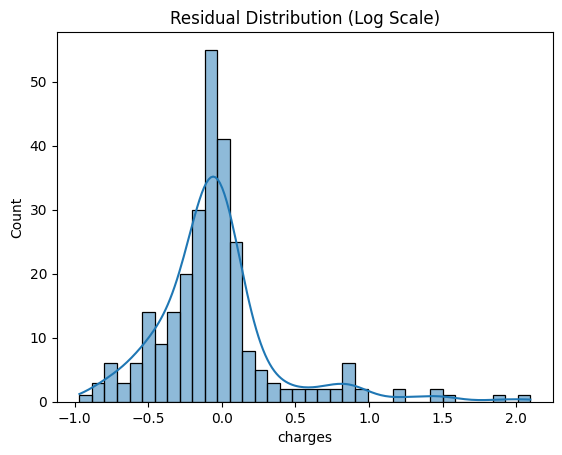

In [21]:

sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Log Scale)")
plt.show()

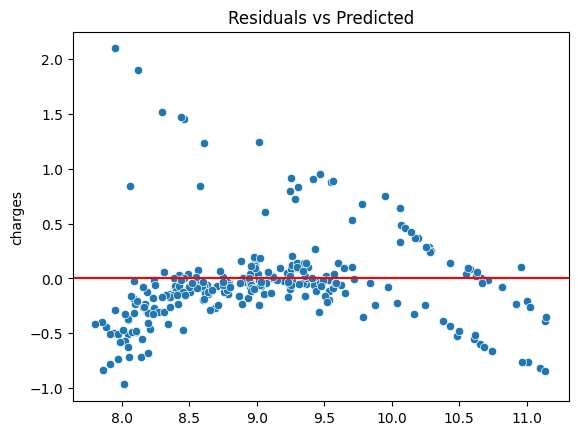

In [22]:
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.title("Residuals vs Predicted")
plt.show()